### Задание

Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - Какие зависимости в данных?
    - Сбалансированы ли классы?
    - Основные статистики признаков
- Разделить данные на train/test
    - Разделить на обучающую и тестовую подвыборки
    - Сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - Какие метрики точности?
    - Какая модель лучше всего справилась?

### Разведочный анализ данных

Подключим библиотеки для анализа данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загружаем данные
df = pd.read_csv("./data/creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


V1 - V28 - числовые входные переменные, которые являются результатом преобразования PCA

Признак "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. 

Признак "Amount" - это сумма транзакции. 

Признак "Class" - это переменная ответа, и она принимает значение 1 в случае мошенничества и 0 в противном случае.

Проверим датасет на наличие пропусков и удалим их, если такие имеются

In [3]:
# Проверим датасет на наличие пропусков и удалим их, если такие имеются
skipping_data = df.isna().sum().sum()
print(f'Количество пропусков в данных: {skipping_data}')
# df = df.drop_duplicates()

Количество пропусков в данных: 0


In [4]:
# Проверим датасет на наличие дубликатов и удалим их, если такие имеются
df.duplicated().sum()

1081

In [5]:
# Удаление 1080 дубликатов
df_no_duplicates = df.drop_duplicates()

# Проверка результата
df_no_duplicates.duplicated().sum()

0

In [6]:
# Изменение исходного DataFrame
df.drop_duplicates(inplace=True)

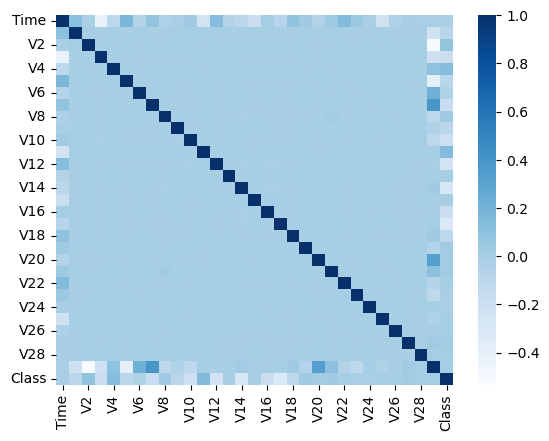

In [7]:
# Посмотрим на матрицу корреляции
sns.heatmap(df.corr(), cbar = True, cmap = "Blues")
plt.show()

Параметры V1-V28 линейно зависят от параметров Time и Amount.

Столбец Time и Amount не скоррелированы с целевой переменной Class.

#### Проверим сбалансированность классов

In [8]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

Видим, что в данной задаче имеется сильный дисбаланс классов

In [9]:
percent = round(df.Class.value_counts()[1] / df.shape[0] * 100, 3)
print(f'Процент мошеннических операций: {percent}%')

Процент мошеннических операций: 0.167%


#### Основные статистики признаков

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


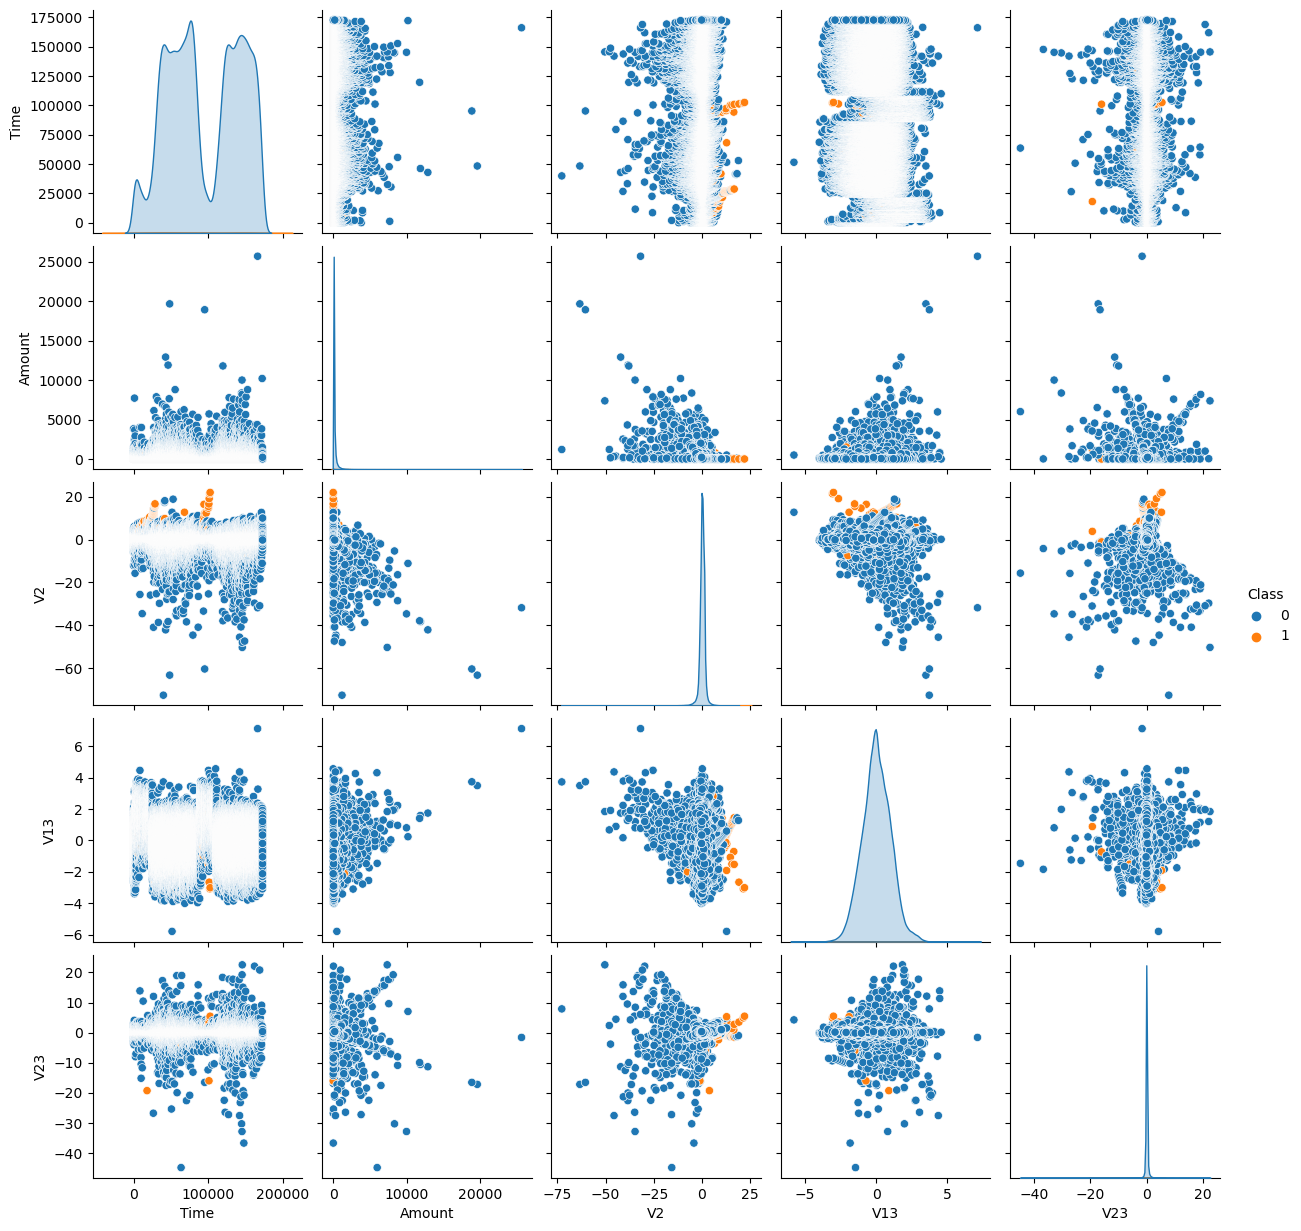

In [11]:
#Исследуем взаимосвязь признаков
parameters = ['Time', 'Amount', 'V2', 'V13', 'V23']
data = df[parameters + ['Class']]
sns.pairplot(data, hue = 'Class', diag_kind = 'auto')
plt.show()

Во многих случаях взаимосвязь нелинейная -> лучше использовать нелинейный модели. 

<Axes: >

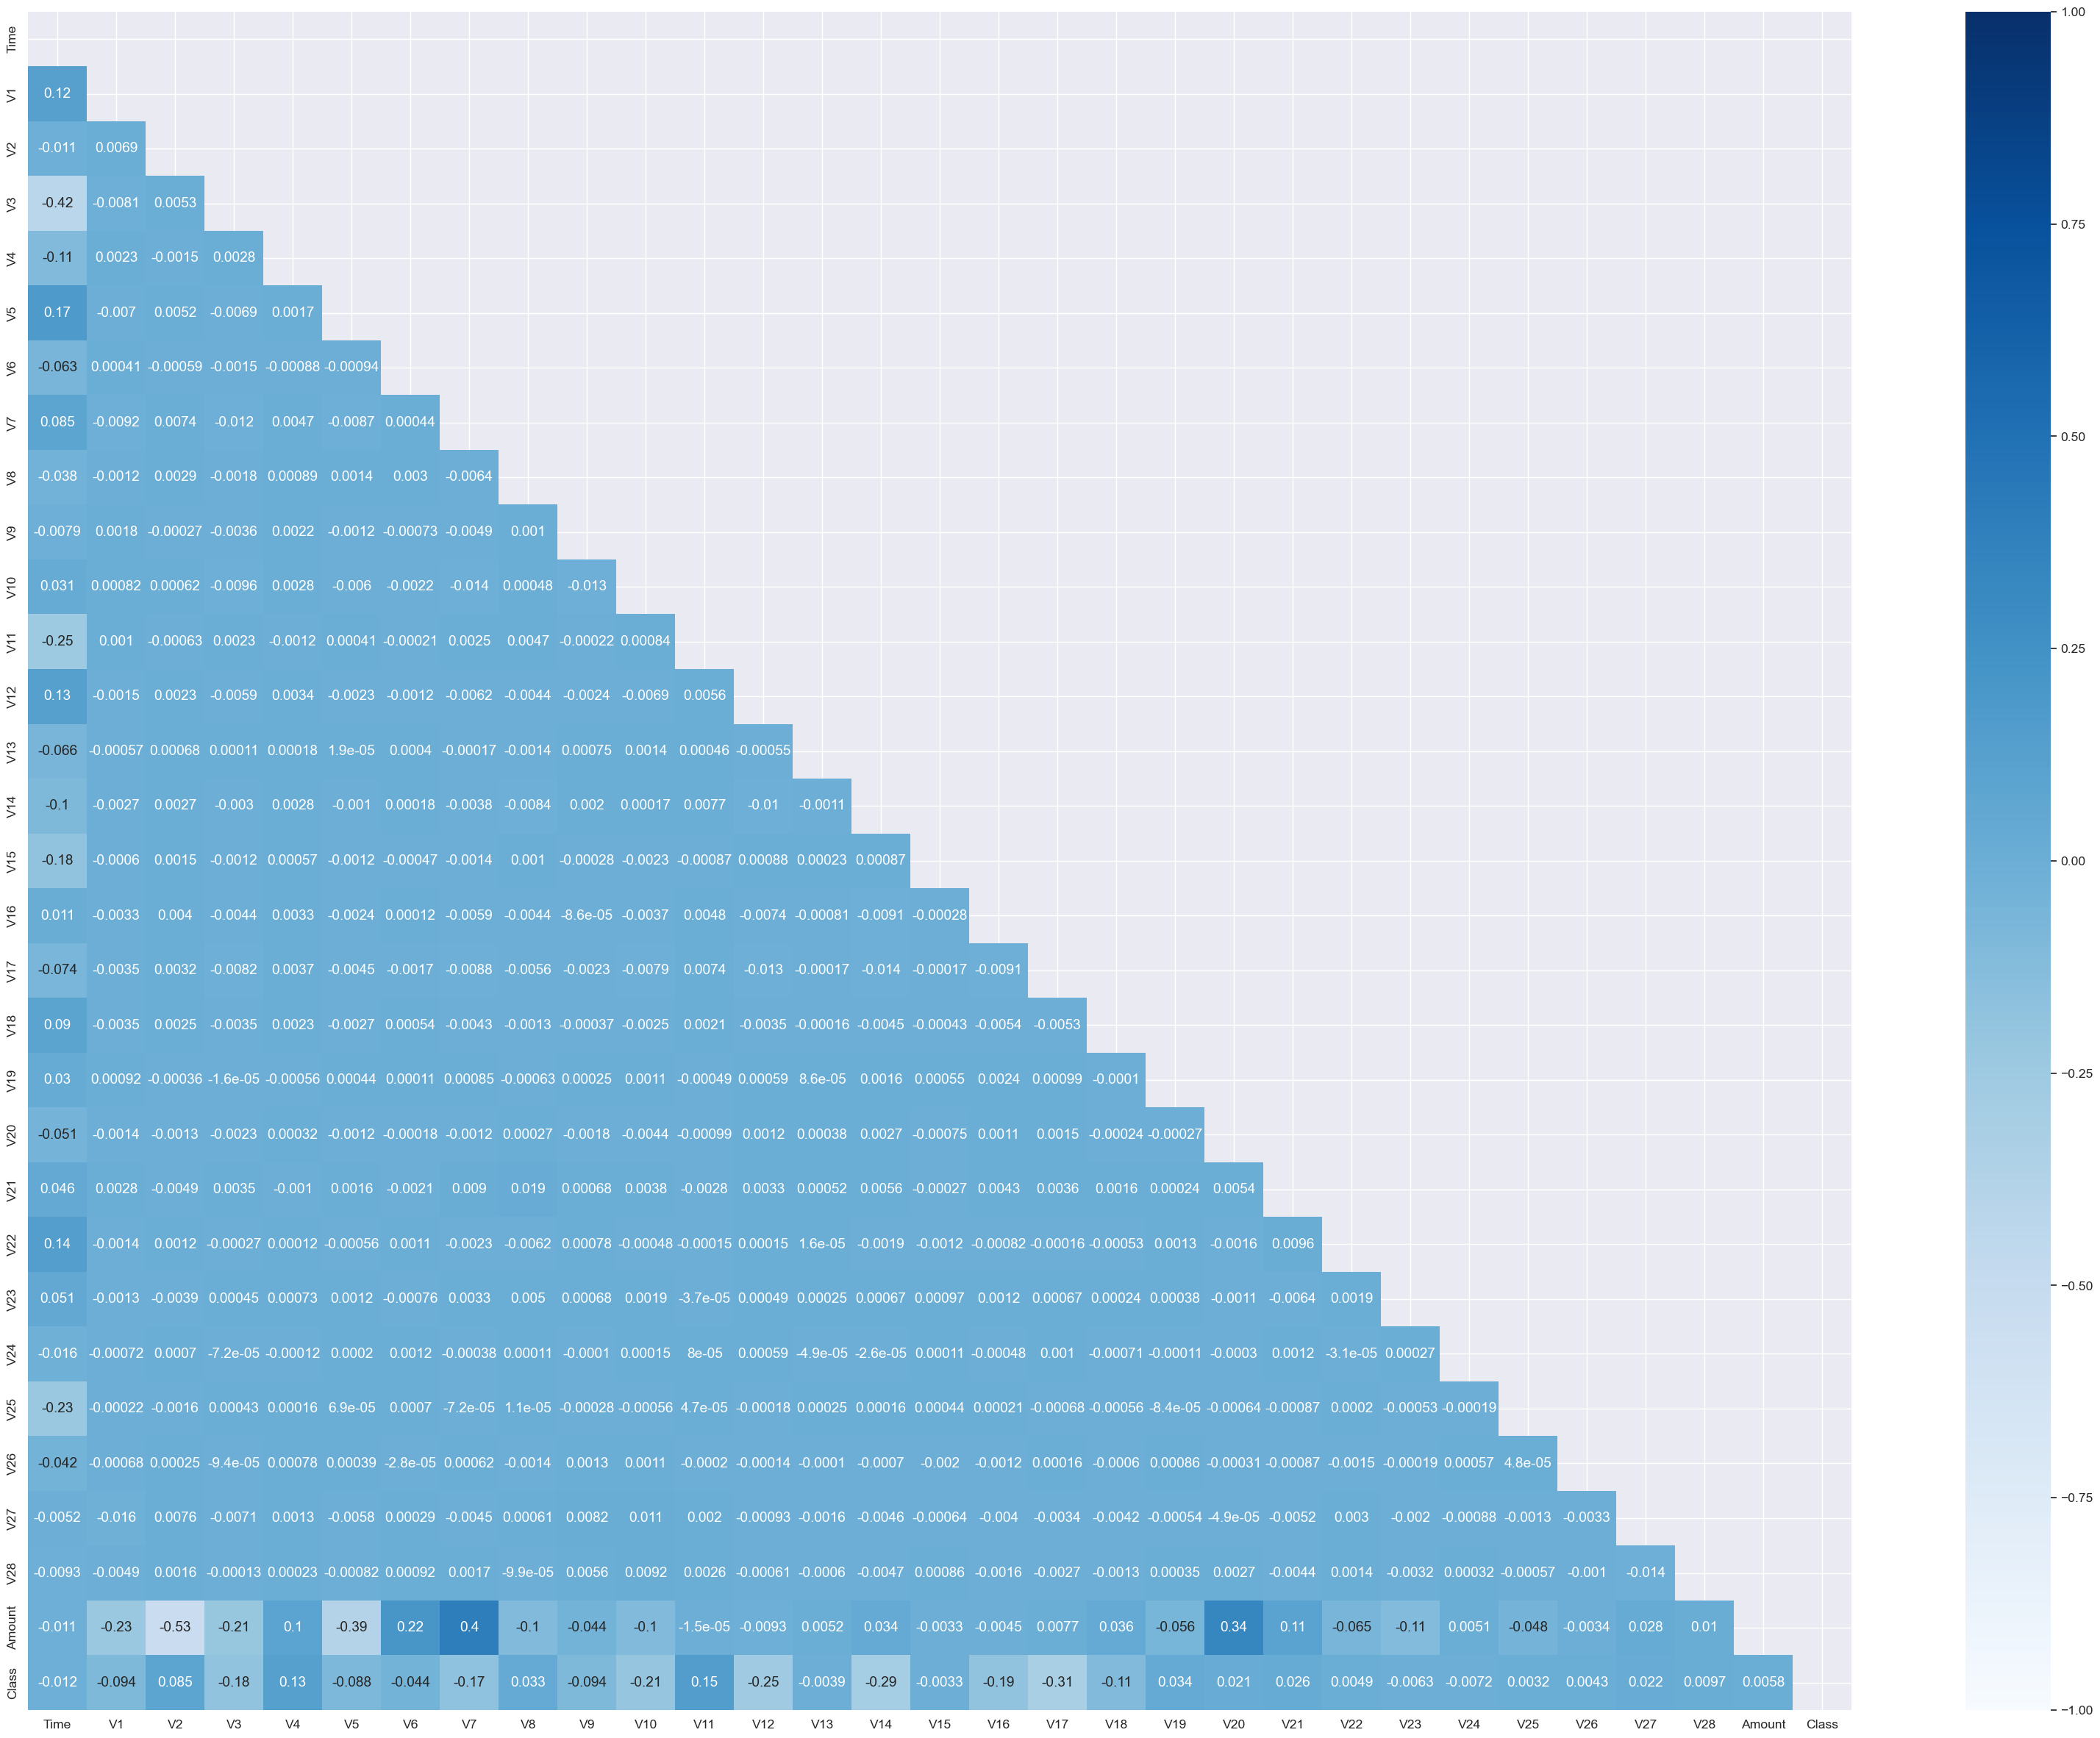

In [12]:
plt.figure(figsize=(40,30))
sns.set(font_scale=1.15)
sns.heatmap(df.corr(),
            cmap='Blues',
            annot=True, 
            vmin=-1, vmax=1,
            mask=np.triu(df.corr()))

Видим, что критерии плохо коррелируют друг с другом. Однако, корреляции между V1-V28 и критериями Time и Amount больше, чем между остальными выличинами. Также видно, что признаки V1 - V28 в большинстве своем имеют связь с целевой переменной.

### Разделение данных на train/test

In [13]:
#Исследуем взаимосвязь признаков
df.loc[(df['Class'] == 1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [14]:
# Разделение данных на обучающую и тестовую выборки в соотношении 80 % и 20 %
from sklearn.model_selection import train_test_split

# Разделяем данные на признаки (X) и метки (y)
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0,
                                                    test_size=0.2,
                                                    stratify=y)

In [15]:
# Cтатистики генеральной выборки
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [16]:
# Статистики обучающей выборки
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,...,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000
mean,94750.938893,0.008213,-0.002460,0.004716,-0.005842,0.000594,0.000797,0.000748,0.000634,-0.002683,...,0.000770,-0.000581,-0.000782,0.000539,0.000555,-0.000164,0.000955,0.001095,0.001012,88.309019
std,47497.059848,1.931856,1.624886,1.504713,1.411102,1.375101,1.330744,1.225550,1.175332,1.096290,...,0.759984,0.721341,0.723254,0.617268,0.605368,0.520326,0.482441,0.396013,0.329968,247.249302
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-9.499423,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,54182.000000,-0.915360,-0.601523,-0.884900,-0.851025,-0.691071,-0.767801,-0.552163,-0.207933,-0.646252,...,-0.211298,-0.228489,-0.542763,-0.161583,-0.354321,-0.317078,-0.327043,-0.070694,-0.052765,5.600000
50%,84613.000000,0.019737,0.063571,0.181686,-0.026530,-0.054172,-0.274268,0.038603,0.022248,-0.052752,...,-0.062505,-0.029779,0.005401,-0.011192,0.041024,0.016502,-0.051615,0.001350,0.011330,22.000000
75%,139313.250000,1.315404,0.799557,1.027616,0.736409,0.611283,0.397151,0.568575,0.327032,0.595806,...,0.133256,0.185869,0.526807,0.147415,0.439679,0.349942,0.240468,0.091065,0.078465,77.520000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,38.117209,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [17]:
# Cтатистики тестовой выборки
X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,...,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000
mean,95051.628185,-0.003265,-0.010832,-0.010799,0.008535,0.006762,-0.008885,0.006010,-0.006810,0.002753,...,-0.002142,0.000471,0.003053,-0.001164,-0.001150,-0.000507,-0.003074,0.004434,-0.001311,89.127349
std,47416.602486,2.011396,1.731221,1.524403,1.426398,1.384612,1.336651,1.236086,1.193821,1.092295,...,0.808750,0.734098,0.729712,0.648807,0.606664,0.524787,0.480489,0.394660,0.320140,262.623422
min,2.000000,-41.928738,-63.344698,-33.680984,-5.251492,-40.427726,-21.929312,-28.215112,-50.420090,-9.481456,...,-21.964898,-22.889347,-10.933144,-32.828995,-2.822684,-8.696627,-2.534330,-8.839766,-8.424041,0.000000
25%,54297.750000,-0.918296,-0.596403,-0.908194,-0.846339,-0.685710,-0.773295,-0.554272,-0.211774,-0.636702,...,-0.211940,-0.227482,-0.542402,-0.162104,-0.354820,-0.319319,-0.325689,-0.070364,-0.053049,5.680000
50%,85143.000000,0.022765,0.065587,0.172127,-0.005545,-0.050920,-0.278802,0.050034,0.020523,-0.049744,...,-0.061769,-0.028452,0.011392,-0.010995,0.040977,0.015217,-0.054529,0.002024,0.011135,22.070000
75%,139236.250000,1.319969,0.802650,1.025090,0.752185,0.615703,0.395077,0.577300,0.321264,0.596490,...,0.133044,0.187653,0.534133,0.148866,0.440057,0.353753,0.238865,0.091862,0.077458,77.500000
max,172785.000000,2.446505,18.902453,4.101716,16.715537,32.911462,23.917837,44.054461,19.168327,9.112555,...,39.420904,22.588989,7.248763,20.803344,3.998294,5.826159,3.463246,10.507884,15.632689,19656.530000


Статистики генеральной, обучающей и тестовой выборок схожи.

Так как данные несбалансированы, то нужно будет использовать сэмплирование. Будем использовать пересэмплирование на обучающей выборке.

In [18]:
#!pip uninstall scikit-learn --yes
#!pip uninstall imblearn --yes
#!pip install scikit-learn==1.2.2
#!pip install imblearn

In [19]:
from imblearn.over_sampling import RandomOverSampler

# Используем RandomOverSampler для увеличения
over_sampler = RandomOverSampler(sampling_strategy='minority')
# Пересэмплирование
X_resampled, y_resampled = over_sampler.fit_resample(X_train, y_train)

# Новое количество записей в каждом классе
print("Количество записей после пересэмплирования:")
print(pd.Series(y_resampled).value_counts())

Количество записей после пересэмплирования:
Class
0    226602
1    226602
Name: count, dtype: int64


### Внесло ли сэмплирование данных дисперсию в начальный датасет?

In [20]:
X_resampled.describe()-X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,...,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000,226224.000000
mean,-7031.991307,-2.223752,1.687087,-3.322180,2.213469,-1.423279,-0.697233,-2.574797,0.376866,-1.245005,...,0.208662,0.239059,0.052211,-0.045928,-0.058766,0.014648,0.030230,0.106912,0.040472,18.321909
std,978.690120,3.384757,1.976649,4.467473,1.763553,2.701387,0.358193,4.402194,3.035809,1.193794,...,0.358268,1.445070,0.296930,0.614224,-0.037735,0.169937,-0.007212,0.553809,0.122976,5.501209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8719.000000,-1.915624,0.415704,-4.162779,0.767243,-0.956479,-0.764665,-2.453790,0.004604,-1.567341,...,0.024320,0.055694,0.020829,-0.081852,-0.046453,-0.006282,0.037427,0.009815,-0.005432,-4.100000
50%,-4755.000000,-0.810502,0.866745,-1.480491,1.312774,-0.347127,-0.365468,-0.667354,0.136105,-0.655365,...,0.090647,0.185563,0.024218,-0.020539,-0.037851,0.027344,0.038526,0.049083,0.021816,-3.040000
75%,-4547.250000,-0.252758,1.973524,-0.675174,3.299578,-0.126221,-0.325892,-0.276247,0.516683,-0.421590,...,0.305547,0.455342,0.064734,0.050437,-0.075684,0.044154,0.092545,0.363786,0.140556,22.470000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
y_resampled.describe()-y_train.describe()

count    226224.000000
mean          0.498335
std           0.459226
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           0.000000
Name: Class, dtype: float64

Действительно, можно заметить, что тестовая и обучающая выборки имеют разные распределения

### Обучение модели классификации

#### 1. Логистическая регрессия (Logistic Regression)

Для работы с несбалансированными датасетами удобно воспользоваться одним из базовых алгоритмов машинного обучения - логистической регрессией.

In [22]:
# Используемые метрики точности
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import time

In [23]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [24]:
from sklearn.linear_model import LogisticRegression

# Объект класса LogisticRegression
logreg = LogisticRegression(random_state=21, max_iter=1000, multi_class='multinomial')

# Обучение модели
logreg.fit(X_train, y_train)

# Прогноз
y_pred_logreg = logreg.predict(X_test)

In [25]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

Accuracy: 0.9992246149508336

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.63      0.73        95

    accuracy                           1.00     56746
   macro avg       0.93      0.82      0.87     56746
weighted avg       1.00      1.00      1.00     56746



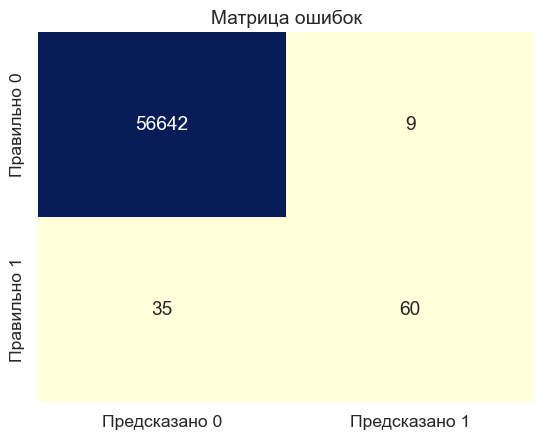

In [26]:
#Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, y_pred_logreg)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

In [27]:
# Обучим модель Logistic Regression на пересэмплированных данных
logreg_resampled = LogisticRegression(random_state=21, max_iter=1000, multi_class='multinomial')

# Обучение модели
logreg_resampled.fit(X_resampled, y_resampled)

# Прогноз
y_pred_logreg_resampled = logreg_resampled.predict(X_test)

In [28]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_resampled))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg_resampled))

Accuracy: 0.9681563458217319

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.91      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.94      0.54     56746
weighted avg       1.00      0.97      0.98     56746



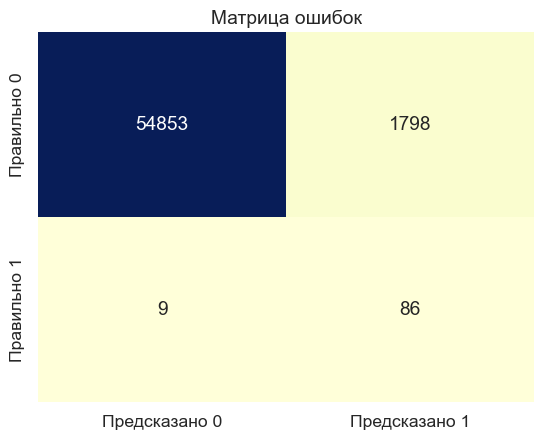

In [29]:
#Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, y_pred_logreg_resampled)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

#### 2. Алгоритм KNN (KNeighborsClassifier)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Объект класса KNN
knn = KNeighborsClassifier()

# Обучение модели
knn.fit(X_train, y_train)

# Прогноз
y_pred_knn = knn.predict(X_test)

In [31]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.9983611179642617

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       1.00      0.02      0.04        95

    accuracy                           1.00     56746
   macro avg       1.00      0.51      0.52     56746
weighted avg       1.00      1.00      1.00     56746



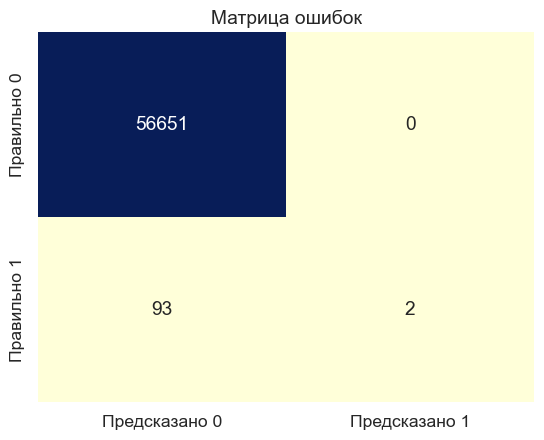

In [32]:
# Оценка качества модели
Confusion_Matrix = confusion_matrix(y_test, y_pred_knn)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

In [33]:
# Обучим модель KNN на пересэмплированных данных
knn_resampled = KNeighborsClassifier()
knn_resampled.fit(X_resampled, y_resampled)

# Предсказания на тестовой выборке
y_pred_knn_resampled = knn_resampled.predict(X_test)

In [55]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_knn_resampled))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn_resampled))

Accuracy: 0.9972509075529553

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.20      0.21      0.20        95

    accuracy                           1.00     56746
   macro avg       0.60      0.60      0.60     56746
weighted avg       1.00      1.00      1.00     56746



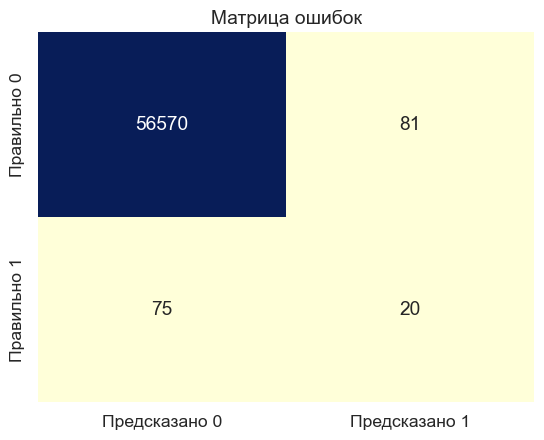

In [35]:
# Оценка качества модели
Confusion_Matrix = confusion_matrix(y_test, y_pred_knn_resampled)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

#### 3. CatBoost

In [36]:
# pip install catboost

In [37]:
from catboost import CatBoostClassifier

# Объект класса CatBoostClassifier
catboost = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, loss_function='Logloss', random_state=42)

# Обучение модели
catboost.fit(X_train, y_train, verbose=0)

# Прогноз
y_pred_catboost = catboost.predict(X_test)

In [38]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("\nClassification Report:\n", classification_report(y_test, y_pred_catboost))

Accuracy: 0.9995946850879357

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.96      0.79      0.87        95

    accuracy                           1.00     56746
   macro avg       0.98      0.89      0.93     56746
weighted avg       1.00      1.00      1.00     56746



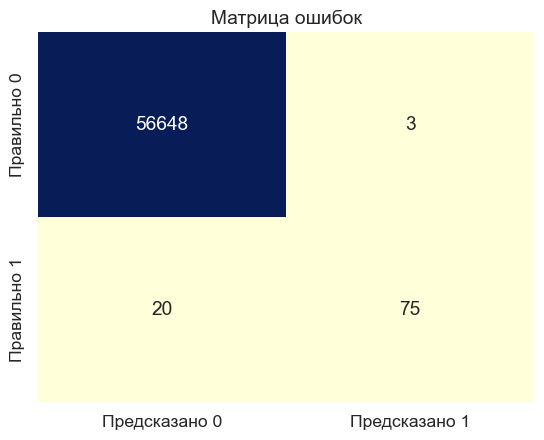

In [39]:
# Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, y_pred_catboost)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

In [40]:
# Обучим модель CatBoost на пересэмплированных данных
catboost_resampled = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, loss_function='Logloss', random_state=42)
catboost_resampled.fit(X_resampled, y_resampled, verbose=0)

# Прогноз
y_pred_catboost_resampled = catboost_resampled.predict(X_test)

In [41]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred_catboost_resampled))
print("\nClassification Report:\n", classification_report(y_test, y_pred_catboost_resampled ))

Accuracy: 0.9995770627004547

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.90      0.84      0.87        95

    accuracy                           1.00     56746
   macro avg       0.95      0.92      0.93     56746
weighted avg       1.00      1.00      1.00     56746



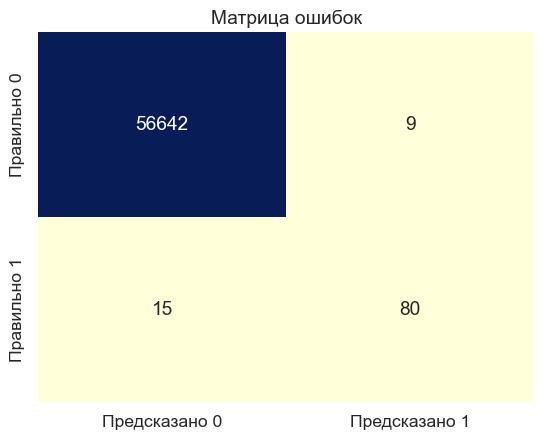

In [42]:
# Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, y_pred_catboost_resampled)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

#### 4. DecisionTree

In [43]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(max_depth=3)
DecisionTree.fit(X_train, y_train)
DecisionTree_y_pred = DecisionTree.predict(X_test)

In [44]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, DecisionTree_y_pred))
print("\nClassification Report:\n", classification_report(y_test, DecisionTree_y_pred))

Accuracy: 0.9993832164381631

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.88      0.74      0.80        95

    accuracy                           1.00     56746
   macro avg       0.94      0.87      0.90     56746
weighted avg       1.00      1.00      1.00     56746



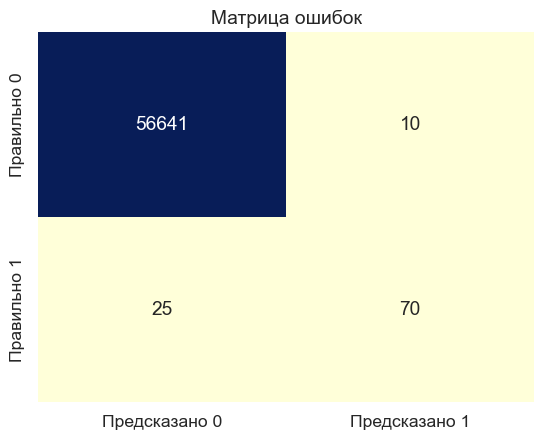

In [45]:
# Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, DecisionTree_y_pred)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

In [46]:
# Обучим модель DecisionTree на пересэмплированных данных

DecisionTree_resampled = DecisionTreeClassifier(max_depth=3)
DecisionTree_resampled.fit(X_resampled, y_resampled)
DecisionTree_y_pred_resampled = DecisionTree_resampled.predict(X_test)

In [47]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, DecisionTree_y_pred_resampled))
print("\nClassification Report:\n", classification_report(y_test, DecisionTree_y_pred_resampled))

Accuracy: 0.9478729778310365

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     56651
           1       0.03      0.92      0.06        95

    accuracy                           0.95     56746
   macro avg       0.51      0.93      0.51     56746
weighted avg       1.00      0.95      0.97     56746



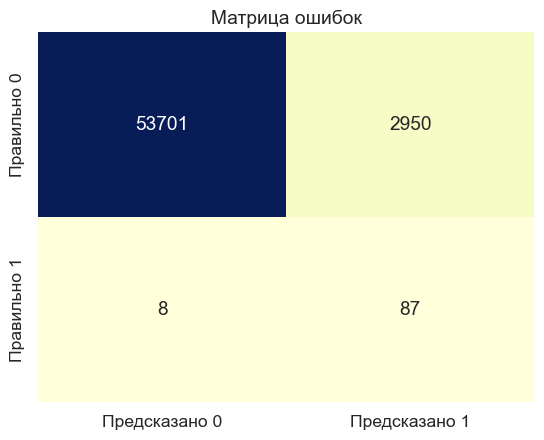

In [48]:
# Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, DecisionTree_y_pred_resampled)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

# сравнить катбуст и десижн три

#### 5. SVM

In [49]:
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)

In [50]:
# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))

Accuracy: 0.9986959433264019

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.71      0.37      0.49        95

    accuracy                           1.00     56746
   macro avg       0.86      0.68      0.74     56746
weighted avg       1.00      1.00      1.00     56746



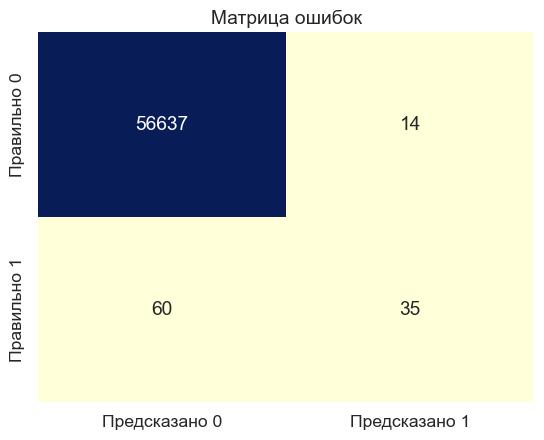

In [51]:
# Выведем матрицу ошибок
Confusion_Matrix = confusion_matrix(y_test, svm_y_pred)

sns.heatmap(Confusion_Matrix, annot=True, fmt="d", cbar=False, cmap='YlGnBu',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

### Сводная таблица

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# DataFrame для хранения результатов
results_df = pd.DataFrame(columns=['Model', 'Sampling', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

# Функция для добавления результатов в DataFrame
def add_result(model_name, sampling_technique, y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    results_df.loc[len(results_df)] = [model_name, sampling_technique, precision, recall, f1, accuracy]
    
# Добавление результатов
add_result('Logistic Regression', 'Unsampled', y_test, y_pred_logreg)
add_result('KNN', 'Unsampled', y_test, y_pred_knn)
add_result('KNN', 'Resampled', y_test, y_pred_knn_resampled)
add_result('CatBoost', 'Unsampled', y_test, y_pred_catboost)
add_result('CatBoost', 'Resampled', y_test, y_pred_catboost_resampled)
add_result('DecisionTree', 'Unsampled', y_test, DecisionTree_y_pred)
add_result('DecisionTree', 'Resampled', y_test, DecisionTree_y_pred_resampled)
add_result('SVM', 'Unsampled', y_test, svm_y_pred)

print(results_df)

                 Model   Sampling  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression  Unsampled   0.869565  0.631579  0.731707  0.999225
1                  KNN  Unsampled   1.000000  0.021053  0.041237  0.998361
2                  KNN  Resampled   0.198020  0.210526  0.204082  0.997251
3             CatBoost  Unsampled   0.961538  0.789474  0.867052  0.999595
4             CatBoost  Resampled   0.898876  0.842105  0.869565  0.999577
5         DecisionTree  Unsampled   0.875000  0.736842  0.800000  0.999383
6         DecisionTree  Resampled   0.028647  0.915789  0.055556  0.947873
7                  SVM  Unsampled   0.714286  0.368421  0.486111  0.998696


Precision (точность) - это мера того, сколько объектов, отнесенных к положительному классу, действительно принадлежат к этому классу. Она вычисляется как отношение числа верно классифицированных положительных примеров к общему числу положительных примеров.

Recall (полнота) - это мера того, насколько успешно модель обнаруживает все положительные примеры. Она вычисляется как отношение числа верно классифицированных положительных примеров к общему числу фактических положительных примеров в данных.

F1-score (F1-мера) - среднее гармоническое между точностью и полнотой. Она используется для оценки сбалансированности модели, учитывающую как точность, так и полноту.

Support - это количество фактических встречаемостей каждого класса в тестовом наборе данных.

Выводы по сводной таблице:
Модели KNN, CatBoost на сэмплированных данных, судя по метрике f1, лучше этих же моделей на несэмплированных данных. Модель DecisionTree - наоборот (несмотря на то, что метрика recall улучшилась, сильно ухудшилась метрика precision).

Модель CatBoost на сэмплированных и несэмплированных данных дает лучшие результаты.

### Запуск обученных на сэмплированных данных моделей на исходной выборке

In [54]:
# Предсказание на исходной выборке для LogisticRegression
y_pred_LR = logreg.predict(X)
print("Accuracy:", accuracy_score(y, y_pred_LR))
print("\nClassification Report:\n", classification_report(y, y_pred_LR))

# Предсказание на исходной выборке для KNN
y_pred_KNN = knn.predict(X)
print("Accuracy:", accuracy_score(y, y_pred_KNN))
print("\nClassification Report:\n", classification_report(y, y_pred_KNN))

# Предсказание на исходной выборке для CatBoost
y_pred_CB = catboost.predict(X)
print("Accuracy:", accuracy_score(y, y_pred_CB))
print("\nClassification Report:\n", classification_report(y, y_pred_CB))

# Предсказание на исходной выборке для DecisionTree
y_pred_DT = DecisionTree.predict(X)
print("Accuracy:", accuracy_score(y, y_pred_DT))
print("\nClassification Report:\n", classification_report(y, y_pred_DT))

# Предсказание на исходной выборке для SVM
y_pred_SVM = svm.predict(X)
print("Accuracy:", accuracy_score(y, y_pred_SVM))
print("\nClassification Report:\n", classification_report(y, y_pred_SVM))

Accuracy: 0.9991259172581998

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.82      0.60      0.70       473

    accuracy                           1.00    283726
   macro avg       0.91      0.80      0.85    283726
weighted avg       1.00      1.00      1.00    283726

Accuracy: 0.9984069137125254

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       1.00      0.04      0.09       473

    accuracy                           1.00    283726
   macro avg       1.00      0.52      0.54    283726
weighted avg       1.00      1.00      1.00    283726

Accuracy: 0.9997673812058112

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.99      0.87      0.93       473

    accuracy        

### Вывод

По итогу работы было обучено пять моделей для обнаружения мошенничества с кредитными картами: LogisticRegression, KNeighborsClassifier, CatBoostClassifier, DecisionTree, CVM. 

Было проведено сравнение семплированных и несэмплированных данных, которое показало, что распределения признаков тестовой и обучающей выборки довольно сильно различаются между собой. 
Также была показана сводная таблица по результатам использования всех методов, которая позволяет сделать вывод иcходя из полученных метрик, что лучшего результата добилась модель CatBoostClassifier на сэмплированных данных.

В конце было проведено применение обученных на сэмплированных данных моделей на исходной выборке, котрое показало более точные результаты, так как тестовая выборка содержится в исходной.